In [1]:
%cd /content/drive/MyDrive/ENS491\ Bitirme\ Projesi/Tests/Design \A/Swin3D

/content/drive/.shortcut-targets-by-id/10zTDcXHUyEVA0OzFw5rGtexJIwNrqbab/ENS491 Bitirme Projesi/Tests/Design A/Swin3D


In [2]:
import torch
print(torch.__version__)

2.3.0+cu121


In [3]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 32.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [4]:
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

!pip install tensorflow_graphics
import tensorflow as tf
import tensorflow_graphics.geometry.transformation as tfg_transformation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.7/694.7 kB 47.8 MB/s eta 0:00:00


In [5]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt



# Load the image file
image_path = "/content/drive/.shortcut-targets-by-id/10zTDcXHUyEVA0OzFw5rGtexJIwNrqbab/ENS491 Bitirme Projesi/Tests/fire_color/frame-000000.color.png"
image = Image.open(image_path)



# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])


# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

# Print the shape and data type of the tensor
print("Tensor shape:", tensor_image.shape)
print("Tensor data type:", tensor_image.dtype)

# Permute dimensions to match the expected shape (B, H, W, C)
tensor_image = tensor_image.permute(0, 2, 3, 1)

Tensor shape: torch.Size([1, 3, 224, 224])
Tensor data type: torch.float32


In [6]:
def window_partition(x, patch_size=4):
    """
    Args:
        x: (B, H, W, C)
        patch_size (int): patch size (Default: 4)

    Returns:
        patches: (num_patches * B, patch_size, patch_size, C)
                 (num_windows * B, patch_size, patch_size, C)
    """

    B, H, W, C = x.shape

    # Calculate the number of patches in each dimension
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size

    # Convert to (B, num_patches_h, patch_size, num_patches_w, patch_size, C)
    x = x.view(B, num_patches_h, patch_size, num_patches_w, patch_size, C)

    # Convert to (B, num_patches_h, num_patches_w, patch_size, patch_size, C)
    patches = x.permute(0, 1, 3, 2, 4, 5).contiguous()

    # Efficient Batch Computation - Convert to (B * num_patches_h * num_patches_w, patch_size, patch_size, C)
    patches = patches.view(-1, patch_size, patch_size, C)

    return patches

In [ ]:
# Call the window_partition function on the tensor_image
window_size = 4
windows = window_partition(tensor_image, window_size)

num_patches, patch_size, _, _ = windows.shape

# Print the shape of the output windows
print("Windows shape:", windows.shape)

print("num_patches ",num_patches)

# Calculate the number of rows and columns in the grid
num_rows = int(num_patches ** 0.5)
num_cols = num_patches // num_rows

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over the patches and plot them
for i, ax in enumerate(axs.flat):
    patch = windows[i].numpy()
    ax.imshow(patch)
    ax.axis("off")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# (224/4 * 224/4 =56*56 = 3136 patches of size 4*4)

Windows shape: torch.Size([3136, 4, 4, 3])
num_patches  3136


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already obtained the windows tensor

# Iterate over the windows and display them
num_windows = windows.shape[0]
print("Total number of windows:", num_windows)
for i in range(len(windows)):
    window = windows[i]  # Get a single window

    # Convert the window tensor to a numpy array and transpose dimensions
    window_np = window.numpy().transpose(1, 0, 2)

    # Normalize the window values to [0, 1] range
    window_np = (window_np - window_np.min()) / (window_np.max() - window_np.min())

    # Display the window image
    plt.imshow(window_np)
    plt.axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Lets use PatchEmbed

class PatchEmbed(nn.Module):
    """ Convert image to patch embedding

    Args:
        img_size (int): Image size (Default: 224)
        patch_size (int): Patch token size (Default: 4)
        in_channels (int): Number of input image channels (Default: 3)
        embed_dim (int): Number of linear projection output channels (Default: 96)
        norm_layer (nn.Module, optional): Normalization layer (Default: None)
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size) # (img_size, img_size) to_2tuple simply convert t to (t,t)
        patch_size = to_2tuple(patch_size) # (patch_size, patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]] # (num_patches, num_patches)

        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        # proj layer: (B, 3, 224, 224) -> (B, 96, 56, 56)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        """
        x: (B, C, H, W) Default: (B, 3, 224, 224)
        returns: (B, H//patch_size * W//patch_size, embed_dim) (B, 56*56, 96)
        """
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}]) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."

        # (B, 3, 224, 224) -> (B, 96, 56, 56)
        x = self.proj(x)

        # (B, 96, 56, 56) -> (B, 96, 56*56)
        x = x.flatten(2)

        # (B, 96, 56*56) -> (B, 56*56, 96): 56 refers to the number of patches
        x = x.transpose(1, 2)

        if self.norm is not None:
            x = self.norm(x)

        return x

In [ ]:
 #Load the image file
image_path = "/content/drive/.shortcut-targets-by-id/10zTDcXHUyEVA0OzFw5rGtexJIwNrqbab/ENS491 Bitirme Projesi/Tests/fire_color/frame-000000.color.png"
image = Image.open(image_path)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])

# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

patch_embed = PatchEmbed(img_size=224, patch_size=4, in_chans=3, embed_dim=96)

embedding = patch_embed(tensor_image)


patches = patch_embed(tensor_image)
# Print the shape of the output patches
print("Patches shape:", patches.shape)   # 96 is embedding dimension, 3136 patches 224/4 * 224/4

embedding

Patches shape: torch.Size([1, 3136, 96])


tensor([[[ 0.5247, -0.5042,  0.1058,  ...,  0.3826, -0.2362, -0.4293],
         [ 0.5352, -0.5222,  0.1000,  ...,  0.3894, -0.2485, -0.4653],
         [ 0.5493, -0.5278,  0.1058,  ...,  0.3993, -0.2631, -0.4784],
         ...,
         [ 0.2815, -0.3746,  0.0313,  ...,  0.2509, -0.0874, -0.1867],
         [ 0.2947, -0.3739,  0.0356,  ...,  0.2546, -0.0596, -0.1691],
         [ 0.2857, -0.3076,  0.0315,  ...,  0.2843, -0.0818, -0.1958]]],
       grad_fn=<TransposeBackward0>)

In [ ]:
print("First patch embedding vector:", patches[0, 0])

# 96 values in every patch because 96 is embedding dimension we mentioned above

#To access the second patch's embedding vector, you can use patches[0, 1]

First patch embedding vector: tensor([ 0.5247, -0.5042,  0.1058,  0.0669,  0.0529, -0.7282, -0.2394,  0.6606,
         0.1031, -0.1233, -0.0122,  0.2972,  0.1003,  0.0665,  0.1919,  0.0589,
        -0.3866, -0.3566,  0.1258, -0.1686,  0.2055, -0.1693,  0.8109,  0.2714,
         0.5512,  0.2501, -0.1179,  0.2113, -0.6824,  0.5185, -0.5501, -0.5126,
        -0.4396,  0.5778, -0.4794, -0.7897,  0.4178, -0.3000, -0.6656, -0.5826,
        -0.4873, -0.8225, -0.4655,  0.8541, -0.0457, -0.4494, -0.1637,  0.0302,
        -0.0863,  0.2016,  0.6935, -0.0655,  0.6787, -0.3888,  0.1191, -0.0291,
        -0.5042,  0.2760,  0.6194,  0.0228, -0.3576,  0.0571,  0.4606,  0.3843,
        -0.0037, -0.0838, -0.4709, -0.9180,  0.0796, -0.1032,  0.4125,  0.1319,
         0.5060,  0.2192, -0.2463, -0.0727, -0.2334, -0.8852, -0.0826,  0.3680,
         0.2606, -0.2179, -0.0183,  0.2885, -0.4308, -0.5491, -0.1412, -0.8485,
        -0.4937,  0.9445, -0.4221,  0.3867,  0.2740,  0.3826, -0.2362, -0.4293],
       gr

In [ ]:
from swin_functions_and_classes import *


stage_1 = BasicLayer(dim=96, input_resolution=(56, 56), depth=2, num_heads=4, window_size=7)

# Pass the patch embeddings through the BasicLayer
output = stage_1(embedding)
print(output.shape)
output

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 3136, 96])


tensor([[[-0.0902,  0.5772, -0.2980,  ...,  0.3073, -0.7675,  0.6484],
         [-0.0825,  0.5566, -0.3050,  ...,  0.3139, -0.7747,  0.6002],
         [-0.0740,  0.5508, -0.2946,  ...,  0.3265, -0.7840,  0.5834],
         ...,
         [-0.2181,  0.3336, -0.4525,  ...,  0.1183, -0.7347,  0.8291],
         [-0.2056,  0.3027, -0.4530,  ...,  0.1024, -0.7042,  0.8585],
         [-0.2281,  0.3782, -0.4256,  ...,  0.1390, -0.7406,  0.8237]]],
       grad_fn=<AddBackward0>)

In [ ]:
# PatchMerging

# USing patch merging on the embedding
merge_layer = PatchMerging(input_resolution=(56, 56), dim=96, norm_layer=nn.LayerNorm)
merged_output = merge_layer(output)
print("Merged output shape:", merged_output.shape)    # (1, 28x28, 96*2) # (1, 784, 192)

Merged output shape: torch.Size([1, 784, 192])


In [ ]:
batch_size = merged_output.shape[0]
num_patches = merged_output.shape[1]
num_channels = merged_output.shape[2]

print("Batch size:", batch_size)
print("Number of patches:", num_patches)
print("Number of channels:", num_channels)

Batch size: 1
Number of patches: 784
Number of channels: 192


In [ ]:
# Create an instance of the SwinTransformerBlock class with the desired parameters
block_1 = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=0,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


#  shift_size is set to 3
block_1_shf = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=2,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


# Pass the embedding through the SwinTransformerBlock:
output = block_1(embedding)
output_shf = block_1_shf(embedding)

print(output.shape)
print(output_shf.shape)
print(output)
print(output_shf)

torch.Size([1, 3136, 96])
torch.Size([1, 3136, 96])
tensor([[[ 0.4267, -0.6902,  0.0704,  ...,  0.1429, -0.6840, -0.0487],
         [ 0.4366, -0.7043,  0.0639,  ...,  0.1519, -0.7005, -0.0915],
         [ 0.4548, -0.7092,  0.0702,  ...,  0.1635, -0.7135, -0.1053],
         ...,
         [ 0.1974, -0.7769,  0.0055,  ..., -0.0117, -0.5249,  0.3206],
         [ 0.2230, -0.7693,  0.0221,  ..., -0.0244, -0.4918,  0.3466],
         [ 0.2091, -0.6957, -0.0017,  ...,  0.0074, -0.5128,  0.3220]]],
       grad_fn=<AddBackward0>)
tensor([[[ 0.1988, -0.1371,  0.1003,  ...,  0.3303, -0.7397, -0.4126],
         [ 0.1996, -0.1513,  0.0959,  ...,  0.3382, -0.7485, -0.4438],
         [ 0.2147, -0.1589,  0.0991,  ...,  0.3491, -0.7493, -0.4598],
         ...,
         [ 0.1763,  0.0411,  0.0219,  ...,  0.1359, -0.5657, -0.0939],
         [ 0.1976,  0.0459,  0.0197,  ...,  0.1094, -0.5319, -0.0655],
         [ 0.1855,  0.0785,  0.0220,  ...,  0.1551, -0.5446, -0.1094]]],
       grad_fn=<AddBackward0>)


In [ ]:
model = SwinTransformer()

print(tensor_image.shape)

model(tensor_image).shape

torch.Size([1, 3, 224, 224])


torch.Size([1, 16])

In [ ]:
from zipfile import ZipFile
import io

def getImageFromZip(zipobj, fname, imreadFlag):
  if fname in zipobj.namelist():
    image_data = zipobj.read(fname)
    image_buffer = io.BytesIO(image_data)
    return cv.imdecode(np.frombuffer(image_buffer.getvalue(), np.uint8), imreadFlag)
  else:
    raise ValueError("Error, given file does not exit")

In [ ]:
path =  "/content/drive/.shortcut-targets-by-id/10zTDcXHUyEVA0OzFw5rGtexJIwNrqbab/ENS491 Bitirme Projesi/Tests/"
zip_file = path+"rgbd-scene-time-lapses.zip"
zipf = ZipFile(zip_file, 'r')

Pose information:
  9.9556482e-001	 -6.5185979e-002	 -6.7344189e-002	 -2.2585712e-001	
  8.6272076e-002	  9.1812646e-001	  3.8667411e-001	 -2.9204991e-001	
  3.6626484e-002	 -3.9078209e-001	  9.1970646e-001	  2.8553110e-001	
  0.0000000e+000	  0.0000000e+000	  0.0000000e+000	  1.0000000e+000	



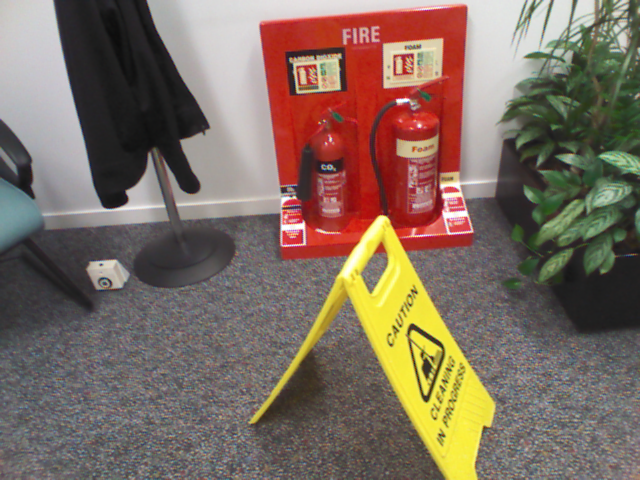

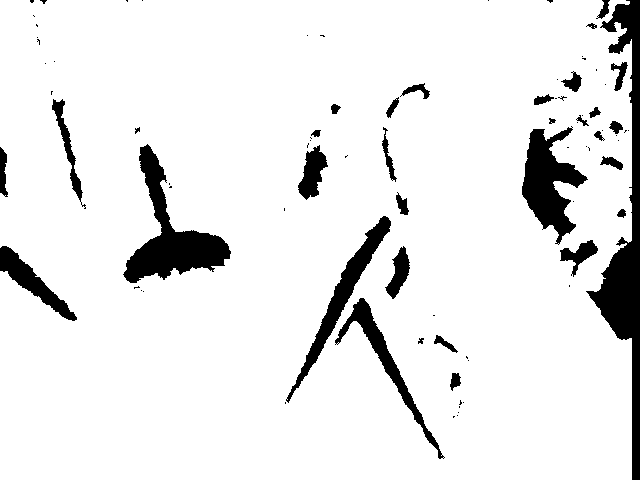

In [ ]:
from zipfile import ZipFile
import io
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Specify the path to the ZIP file
zip_file = "/content/drive/.shortcut-targets-by-id/10zTDcXHUyEVA0OzFw5rGtexJIwNrqbab/ENS491 Bitirme Projesi/Tests/rgbd-scene-time-lapses.zip"

# Open the ZIP file
with ZipFile(zip_file, 'r') as zipf:
    # Specify the file name of the target (pose) file
    pose_file_name = "fire/fire/seq-01/seq-01/frame-000000.pose.txt"

    # Check if the specified target file exists in the ZIP archive
    if pose_file_name in zipf.namelist():
        # Read the contents of the pose file
        with zipf.open(pose_file_name, 'r') as pose_file:
            # Read the contents of the file as text
            pose_contents = pose_file.read().decode('utf-8')

            # Print the contents of the pose file
            print("Pose information:")
            print(pose_contents)

            # Get the file name prefixes for color and depth files
            file_prefix = pose_file_name.replace('.pose.txt', '')

            # Construct the file names for color and depth images
            color_file_name = file_prefix + '.color.png'
            depth_file_name = file_prefix + '.depth.png'

            # Read the color image
            color_image_data = zipf.read(color_file_name)
            color_image = cv2.imdecode(np.frombuffer(color_image_data, np.uint8), cv2.IMREAD_COLOR)

            # Read the depth image
            depth_image_data = zipf.read(depth_file_name)
            depth_image = cv2.imdecode(np.frombuffer(depth_image_data, np.uint8), cv2.IMREAD_UNCHANGED)

            # Display the color and depth images
            cv2_imshow(color_image)
            cv2_imshow(depth_image)
    else:
        print("Specified pose file not found in the ZIP archive.")


In [ ]:
import os

# Get the current working directory
directory = "/content/drive/.shortcut-targets-by-id/10zTDcXHUyEVA0OzFw5rGtexJIwNrqbab/ENS491 Bitirme Projesi/Tests/fire_color"

# Concatenate the current directory with additional directories
train_dir = directory
test_dir = directory
print(path)

/content/drive/.shortcut-targets-by-id/10zTDcXHUyEVA0OzFw5rGtexJIwNrqbab/ENS491 Bitirme Projesi/Tests/


In [ ]:
from zipfile import ZipFile
import io
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class ZipImageDataset(Dataset):
    def __init__(self, zip_path, subset='train', transform=None):
        self.zip_path = zip_path
        self.transform = transform

        # Open the ZIP file
        self.zip_file = ZipFile(zip_path, 'r')

        if subset == 'train':
            # Get a list of image file names for training
            self.image_names = [name for name in self.zip_file.namelist() if
                                name.startswith('fire') and
                                (name.find('/seq-01/') != -1 or name.find('/seq-02/') != -1) and
                                name.endswith('.color.png')]
        elif subset == 'test':
            # Get a list of image file names for testing
            self.image_names = [name for name in self.zip_file.namelist() if
                                name.startswith('fire') and
                                (name.find('/seq-03/') != -1 or name.find('/seq-04/') != -1) and
                                name.endswith('.color.png')]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        # Read color image file from ZIP
        color_image_data = self.zip_file.read(self.image_names[idx])
        color_image = Image.open(io.BytesIO(color_image_data))

        # Read pose file from ZIP
        pose_file_name = self.image_names[idx].replace('.color.png', '.pose.txt')
        pose_data = self.zip_file.read(pose_file_name)

        # Parse pose data from string format to a tensor
        pose_data = pose_data.decode('utf-8').strip().split('\t')
        pose_data = [float(value) for value in pose_data]
        pose_tensor = torch.tensor(pose_data, dtype=torch.float32)

        # Apply transformations if specified
        if self.transform:
            color_image = self.transform(color_image)

        return color_image, pose_tensor

# Define your transform pipeline
IMG_SIZE = 224
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Path to your ZIP file
zip_path = "/content/drive/.shortcut-targets-by-id/10zTDcXHUyEVA0OzFw5rGtexJIwNrqbab/ENS491 Bitirme Projesi/Tests/rgbd-scene-time-lapses.zip"

# Create train and test datasets
train_dataset = ZipImageDataset(zip_path, subset='train', transform=manual_transforms)
test_dataset = ZipImageDataset(zip_path, subset='test', transform=manual_transforms)

# Create train and test dataloaders
BATCH_SIZE = 32
#NUM_WORKERS = os.cpu_count()
NUM_WORKERS = 0

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)


In [ ]:
model = SwinTransformer()

torch.Size([3, 224, 224]) tensor([ 0.9777, -0.1801, -0.1078, -0.1602,  0.2007,  0.9525,  0.2288, -0.2105,
         0.0615, -0.2454,  0.9674,  0.3760,  0.0000,  0.0000,  0.0000,  1.0000])


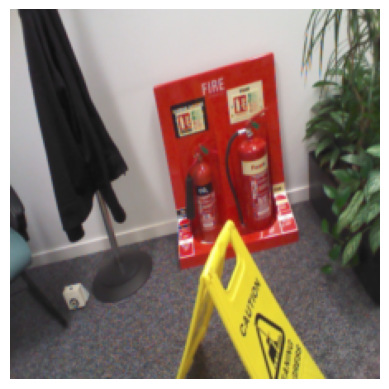

In [ ]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.axis(False);


In [ ]:
import torch
from torch.optim import Adam
import torch.nn as nn
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device, save_dir=None):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Training loop
        model.train()
        train_loss = 0.0
        for images, targets in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs} - Training"):
            # Move data to device
            images = images.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = loss_fn(outputs, targets)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            train_loss += loss.item()

        # Compute average training loss for this epoch
        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Evaluation loop
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for images, targets in tqdm(test_dataloader, desc=f"Epoch {epoch + 1}/{epochs} - Evaluation"):
                # Move data to device
                images = images.to(device)
                targets = targets.to(device)

                # Forward pass
                outputs = model(images)

                # Compute loss
                loss = loss_fn(outputs, targets)

                # Accumulate test loss
                test_loss += loss.item()

            # Compute average test loss for this epoch
            avg_test_loss = test_loss / len(test_dataloader)
            test_losses.append(avg_test_loss)

        # Print training and validation loss for this epoch
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

        # Save the model and loss values every 10 epochs
        if (epoch + 1) % 10 == 0 and save_dir is not None:
            save_checkpoint(model, optimizer, epoch, avg_train_loss, avg_test_loss, save_dir)

    return {
        'train_losses': train_losses,
        'test_losses': test_losses
    }

def save_checkpoint(model, optimizer, epoch, train_loss, test_loss, save_dir):
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    # Save model checkpoint
    checkpoint_path = os.path.join(save_dir, f"epoch_{epoch + 1}_checkpoint.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'test_loss': test_loss
    }, checkpoint_path)



# Assuming you have already defined your model, train and test dataloaders, optimizer, and device
optimizer = Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
save_dir = "swin_checkpoints"

results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=500,
                device=device,
                save_dir=save_dir)


Epoch 1/500 - Evaluation: 100%|██████████| 63/63 [00:40<00:00,  1.55it/s]


Epoch 1/500, Train Loss: 0.3275, Test Loss: 0.1242


Epoch 2/500 - Evaluation: 100%|██████████| 63/63 [00:39<00:00,  1.60it/s]


Epoch 2/500, Train Loss: 0.1014, Test Loss: 0.1051


Epoch 3/500 - Evaluation: 100%|██████████| 63/63 [00:39<00:00,  1.61it/s]


Epoch 3/500, Train Loss: 0.1021, Test Loss: 0.1087


Epoch 4/500 - Evaluation: 100%|██████████| 63/63 [00:39<00:00,  1.61it/s]


Epoch 4/500, Train Loss: 0.1036, Test Loss: 0.1217


Epoch 5/500 - Evaluation: 100%|██████████| 63/63 [00:39<00:00,  1.61it/s]


Epoch 5/500, Train Loss: 0.1035, Test Loss: 0.1057


Epoch 6/500 - Evaluation: 100%|██████████| 63/63 [00:39<00:00,  1.62it/s]


Epoch 6/500, Train Loss: 0.1010, Test Loss: 0.1131


Epoch 7/500 - Evaluation: 100%|██████████| 63/63 [00:39<00:00,  1.61it/s]


Epoch 7/500, Train Loss: 0.0987, Test Loss: 0.1275


Epoch 8/500 - Evaluation: 100%|██████████| 63/63 [00:39<00:00,  1.61it/s]


Epoch 8/500, Train Loss: 0.1036, Test Loss: 0.1131


Epoch 9/500 - Evaluation: 100%|██████████| 63/63 [00:39<00:00,  1.61it/s]


Epoch 9/500, Train Loss: 0.1003, Test Loss: 0.1034


Epoch 10/500 - Evaluation: 100%|██████████| 63/63 [00:39<00:00,  1.61it/s]


Epoch 10/500, Train Loss: 0.1011, Test Loss: 0.1127


Epoch 11/500 - Training:  79%|███████▉  | 50/63 [00:45<00:11,  1.17it/s]

In [ ]:
import torch
from torch.optim import Adam
import torch.nn as nn
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def rotation_matrix_to_quaternion(rotation_matrix):
    # Extract the rotation matrix elements
    r11, r12, r13 = rotation_matrix[:, 0, 0], rotation_matrix[:, 0, 1], rotation_matrix[:, 0, 2]
    r21, r22, r23 = rotation_matrix[:, 1, 0], rotation_matrix[:, 1, 1], rotation_matrix[:, 1, 2]
    r31, r32, r33 = rotation_matrix[:, 2, 0], rotation_matrix[:, 2, 1], rotation_matrix[:, 2, 2]

    # Calculate the quaternion elements
    qw = 0.5 * torch.sqrt(1 + r11 + r22 + r33)
    qx = (r32 - r23) / (4 * qw)
    qy = (r13 - r31) / (4 * qw)
    qz = (r21 - r12) / (4 * qw)

    # Stack the quaternion elements into a single tensor
    quaternion = torch.stack([qx, qy, qz, qw], dim=1)

    return quaternion

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device):
    train_coordinate_losses = []
    train_rotation_losses = []
    test_coordinate_losses = []
    test_rotation_losses = []

    for epoch in range(epochs):
        # Training loop
        model.train()
        train_loss = 0.0
        train_coordinate_loss = 0.0
        train_rotation_loss = 0.0
        for images, targets in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs} - Training"):
            # Move data to device
            images = images.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(images)

            # Reshape targets and outputs to batch_size x 4 x 4
            targets = targets.view(-1, 4, 4)
            outputs = outputs.view(-1, 4, 4)

            # Splitting outputs into rotation and coordinates
            predicted_rotation = outputs[:, :3, :3]
            predicted_coordinates = outputs[:, :3, 3]
            targets_rotation = targets[:, :3, :3]
            targets_coordinates = targets[:, :3, 3]

            # Compute coordinate loss
            coordinate_loss = loss_fn(predicted_coordinates, targets_coordinates)
            train_coordinate_loss += coordinate_loss.item()

            # Compute rotation loss
            predicted_quaternions = rotation_matrix_to_quaternion(predicted_rotation)
            targets_quaternions = rotation_matrix_to_quaternion(targets_rotation)
            rotation_loss = loss_fn(predicted_quaternions, targets_quaternions)
            train_rotation_loss += rotation_loss.item()

            # Compute total loss
            loss = coordinate_loss + rotation_loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            train_loss += loss.item()

        # Compute average training losses for this epoch
        avg_train_loss = train_loss / len(train_dataloader)
        avg_train_coordinate_loss = train_coordinate_loss / len(train_dataloader)
        avg_train_rotation_loss = train_rotation_loss / len(train_dataloader)
        train_coordinate_losses.append(avg_train_coordinate_loss)
        train_rotation_losses.append(avg_train_rotation_loss)

        # Evaluation loop
        model.eval()
        test_loss = 0.0
        test_coordinate_loss = 0.0
        test_rotation_loss = 0.0
        with torch.no_grad():
            for images, targets in tqdm(test_dataloader, desc=f"Epoch {epoch + 1}/{epochs} - Evaluation"):
                # Move data to device
                images = images.to(device)
                targets = targets.to(device)

                # Forward pass
                outputs = model(images)

                # Reshape targets and outputs to batch_size x 4 x 4
                targets = targets.view(-1, 4, 4)
                outputs = outputs.view(-1, 4, 4)

                # Splitting outputs into rotation and coordinates
                predicted_rotation = outputs[:, :3, :3]
                predicted_coordinates = outputs[:, :3, 3]
                targets_rotation = targets[:, :3, :3]
                targets_coordinates = targets[:, :3, 3]

                # Compute coordinate loss
                coordinate_loss = loss_fn(predicted_coordinates, targets_coordinates)
                test_coordinate_loss += coordinate_loss.item()

                # Compute rotation loss
                predicted_quaternions = rotation_matrix_to_quaternion(predicted_rotation)
                targets_quaternions = rotation_matrix_to_quaternion(targets_rotation)
                rotation_loss = loss_fn(predicted_quaternions, targets_quaternions)
                test_rotation_loss += rotation_loss.item()

                # Accumulate test loss
                test_loss += (coordinate_loss + rotation_loss).item()

            # Compute average test losses for this epoch
            avg_test_loss = test_loss / len(test_dataloader)
            avg_test_coordinate_loss = test_coordinate_loss / len(test_dataloader)
            avg_test_rotation_loss = test_rotation_loss / len(test_dataloader)
            test_coordinate_losses.append(avg_test_coordinate_loss)
            test_rotation_losses.append(avg_test_rotation_loss)

        # Print training and validation losses for this epoch
        print(f"Epoch {epoch + 1}/{epochs}, Train Coordinate Loss: {avg_train_coordinate_loss:.4f}, "
              f"Train Rotation Loss: {avg_train_rotation_loss:.4f}, "
              f"Test Coordinate Loss: {avg_test_coordinate_loss:.4f}, "
              f"Test Rotation Loss: {avg_test_rotation_loss:.4f}")

    return {
        'train_coordinate_losses': train_coordinate_losses,
        'train_rotation_losses': train_rotation_losses,
        'test_coordinate_losses': test_coordinate_losses,
        'test_rotation_losses': test_rotation_losses
    }


# Assuming you have already defined your model, train and test dataloaders, optimizer, and device
optimizer = Adam(model.parameters(), lr=3e-3)
loss_fn = nn.MSELoss()

results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)


Epoch 1/10 - Evaluation: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s]


Epoch 1/10, Train Coordinate Loss: nan, Train Rotation Loss: nan, Test Coordinate Loss: nan, Test Rotation Loss: nan


Epoch 2/10 - Evaluation:  38%|███▊      | 24/63 [00:15<00:25,  1.52it/s]


KeyboardInterrupt: 

In [ ]:
checkpoint = torch.load("swin_checkpoints/epoch_10_checkpoint.pth",  map_location=torch.device('cpu'))

In [ ]:
train_loss = checkpoint['train_loss']
test_loss = checkpoint['test_loss']

print(f"Train Loss: {train_loss}")
print(f"Test Loss: {test_loss}")

Train Loss: 0.10110548588018568
Test Loss: 0.11274761189189222


In [ ]:
import torch
from torch.optim import Adam
import torch.nn as nn
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Define your evaluation dataset and dataloader
# Assuming you have already defined test_dataloader and loss_fn

def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Evaluating"):
            # Move data to device
            images = images.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = loss_fn(outputs, targets)

            # Accumulate loss
            total_loss += loss.item()

    # Compute average loss
    avg_loss = total_loss / len(dataloader)
    print(f"Average Loss: {avg_loss:.4f}")
    return avg_loss

# Load the model checkpoint
checkpoint = torch.load("swin_checkpoints/epoch_10_checkpoint.pth", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
loss_fn = nn.MSELoss()
# Evaluate the loaded model
avg_loss = evaluate(model, test_dataloader, loss_fn, device)

Evaluating: 100%|██████████| 63/63 [11:44<00:00, 11.19s/it]

Average Loss: 0.1127
